# A classification of quantum states with neural networks

In quantum physics, all physical quantities of a certain system are described by a quantum state. When a system is composed of two or more parties, such as two or more particles (electrons, atoms, etc...), these can be entangled. This situation underpins quantum correlations between these parties such that we could not study them as independent entities. Figuratively speaking, we could say that two or more entangled particles behave like a whole one and we could not know completely one of them independently from all of the others. In case two or more parties are unentangled, we would say they are separable. 

Quantum entanglement, first discussed in the first decades of the last century, has become increasingly important in some applications such as quantum cryptography and quantum computers. 

Even today there are still some aspects of this topic to explore. One of this is to determine exactly whether an unknown quantum state is entangled or not. In this project, we apply artificial neural networks to make a classification of entangled and separable quantum states. The feature space is given by the complex components of quantum states. The targets are binary and can be either entangled (1) or separable (0).

First, we focus on a special class of quantum states, Werner states. The entangled/separable decision boundary is determined by the real parameter $p_{sym}$, which varies between 0 and 1, and is located at $p_{sym} = 0.5$. Separable states have $p_{sym} \geq 0.5$ and entangled states have $p_{sym} < 0.5$.

Next, we will deal with general quantum states. Unlike the case of Werner states, features of such states are not a linear function of a single parameter like $p_{sym}$. Generally, the decision boundary between entangled and separable states is a highly non-linear function. As a result, while features of Werner states can be casted in a one-dimensional space, the feature space of general states is high-dimensional.

Artificial neural networks are used under supervised approach. First, they learn from a training set made of 20000 states. Next, their classification performance is gauged on a test set composed of 5000 states. The training and the test dataset were artificially generated with *Qutip*, a Python library for quantum computations. States were drawn from a random uniform distribution. 

Since we artificially sampled data, here we do not face any missing-data nor few-data problem unlike other cases. On the other hand, the classification task of quantum states is generally a high-dimensional problem whose exact solution would involve implementing highly non-linear analytical criteria. Among others, this might come with a large computational cost. Neural networks are known to be universal approximators of any possible continuous function (ideally, at arbitrary precision if the network size were infinite). Given this fact, we aim at checking whether neural networks could provide a less expensive and valid alternative to some analytical criteria. In particular, we are interested to investigate whether artificial neural networks with a relatively small size could detect the boundary decision between entangled and separable states at highest accuracy.

## Werner states

In [ ]:
# Code to sample Werner states 

# import Python libraries 

import pandas as pd
import numpy as np
import qutip as qt
import random 

dimspace = 2 # dimensional parameter (the single state represents a qubit, i.e. a two-level system)

nrstates_train = 20000 # size of the training set
nrstates_test = 5000 # size of the test set

# Pauli matrices and identity 

X = qt.sigmax()
Y = qt.sigmay()
Z = qt.sigmaz()
I = qt.qeye(dimspace)

# Function to sample Werner states

def sampling_Wernerstates(numberOfStates, dimsingle): 


    totalDim = dimsingle**2

    # Creating empty numpy arrays
    states = []
    labelsWER = []
    psym = []

    for k in range(numberOfStates): 

        p_sym = np.random.uniform(0,1) # drawing p_sym from RANDOM UNIFORM DISTRIBUTION into (0,1)

        psym.append(p_sym) # append the value of each p_sym to an empty numpy array 

        # By definition, a Werner state is entangled when p_sym < 0.5 and is separable otherwise.
        # Let us give the binary labels 0 (sep) and 1 (ent) starting from this property. 

        if p_sym >= 0.5:
            labelsWER.append(0) 
        else:
            labelsWER.append(1)

        # Generate the features of each quantum state (rho) using the function named "werner_states" (see below)
        
        rho = werner_states(p_sym, dimsingle)

        rhoFull = rho.full() # convert rho into a numpy array, mantaining its shape

        states.append(rhoFull) # append each state to the empty array densityMatrices



    dmElementsList = [] # empty array that will contain the components of each quantum state
    for m in range(totalDim):
        for n in range(totalDim):
            dmElementsList.append('rho(' + str(m) + ',' + str(n) + ')') # name of each column 

    # pandas dataframes 

    dfDM = pd.DataFrame(np.reshape(states, (numberOfStates, totalDim**2)), columns = dmElementsList) 
    dfpsyms = pd.DataFrame(np.reshape(psym, (numberOfStates, 1)), columns = ["p_sym"])
    dfLabelsWER = pd.DataFrame(np.reshape(labelsWER, (numberOfStates, 1)), columns = ["State type"]) 

    return dfDM, dfpsyms, dfLabelsWER



# function to compute the Werner states

def werner_states(psym, dimsingle):
    
    alpha = ((1-2*psym)*dimsingle+1)/(1-2*psym+dimsingle) # coefficient 
    
    zero_matrix = np.zeros(shape = (dimsingle,dimsingle))  # d x d matrix entirely made of 0 
    
    z_m = qt.Qobj(zero_matrix) # convert the zero_matrix into a quantum object 
    
    P = qt.tensor(z_m*z_m.dag(), z_m*z_m.dag())  # d^2 x d^2 matrix entirely made of 0 
    
    Id = qt.tensor(qt.qeye(dimsingle), qt.qeye(dimsingle))  # identity matrix in a d^2 x d^2 system
    
    for i in range(dimsingle): 
        for j in range(dimsingle):
            ket = qt.basis(dimsingle, i) 
            bra = qt.basis(dimsingle, j) 
            P += qt.tensor(ket*bra.dag(), bra*ket.dag())  # permutation operator

    rho = (Id-alpha*P)/(dimsingle**2-dimsingle*alpha)  # most general form of any Werner state
    
    return rho


werner_train, psym_train, labels_train = sampling_Wernerstates(nrstates_train, dimspace) # training set

werner_test, psym_test, labels_test = sampling_Wernerstates(nrstates_test, dimspace) # test set


# Training data

werner_train.to_csv("werner_train.csv") # features
psym_train.to_csv("psym_train.csv") # p_sym value
labels_train.to_csv("labels_werner_train.csv") # binary targets 0/1

# Test data

werner_test.to_csv("werner_test.csv") # features
psym_test.to_csv("psym_test.csv") # p_sym value 
labels_test.to_csv("labels_werner_test.csv") # binary targets 0/1 

### Dataset structure

Generally, a quantum state is a $4 \times 4$ complex matrix, so it has 16 complex components. Each of them should be split into real and imaginary part, which results in 32 features. 
However, Werner states have a simplified structure, i.e. they have few non-zero real components and no imaginary part. As we will see, drawing the boundary between entangled and separable Werner states is a linear problem. As a result, this task could be carried out with maximal accuracy also with a perceptron, i.e. a neural network with no hidden layers.

In [2]:
# Import Python libraries

import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt 

nrstates_train = 20000 # size of the training set
nrstates_test = 5000 # size of the test set

# Import the datasets

werner_train = pd.read_csv("werner_train.csv") # feature space of the training set
psym_train = pd.read_csv("psym_train.csv") # p_sym of the states in the training dataset
labels_werner_train = pd.read_csv("labels_werner_train.csv") # labels of the training set

werner_test = pd.read_csv("werner_test.csv") # features space of the test set
psym_test = pd.read_csv("psym_test.csv") # Import p_sym of the states in the test dataset 
labels_werner_test = pd.read_csv("labels_werner_test.csv") # labels of the test set

# Drop additional columns, added while importing the datasets

labels_werner_train = labels_werner_train.drop(columns = ["Unnamed: 0"])
labels_werner_test = labels_werner_test.drop(columns = ["Unnamed: 0"])

werner_train = werner_train.drop(columns = ["Unnamed: 0"])
werner_test = werner_test.drop(columns = ["Unnamed: 0"])

psym_train = psym_train.drop(columns = ["Unnamed: 0"])
psym_test = psym_test.drop(columns = ["Unnamed: 0"])

In [3]:
# Show the targets of the training set 
labels_werner_train.head()

,State type
0,1
1,0
2,0
3,1
4,1


In [4]:
# Show the targets of the test set 
labels_werner_test.head()

,State type
0,1
1,0
2,1
3,1
4,1


First, let us check whether the training set and the test set are composed of **balanced classes**. Balanced classes are an important condition for the optimal working of neural networks. Since states of both datasets were drawn from random uniform distribution, we envisage that both training and test set should contain 50\% entangled and 50\% separable states. 

In [5]:
# Composition of the training and of the test datasets  

train_sep = labels_werner_train.loc[labels_werner_train["State type"] == 0].values
train_ent = labels_werner_train.loc[labels_werner_train["State type"] == 1].values

test_sep = labels_werner_test.loc[labels_werner_test["State type"] == 0].values
test_ent = labels_werner_test.loc[labels_werner_test["State type"] == 1].values

train_sep_perc = train_sep.size/nrstates_train*100
train_ent_perc = train_ent.size/nrstates_train*100

test_sep_perc = test_sep.size/nrstates_test*100
test_ent_perc = test_ent.size/nrstates_test*100

print("Percentage of separable states in the training set = {} %".format(round(train_sep_perc,2)))
print("Percentage of entangled states in the training set = {} %".format(round(train_ent_perc,2)))

print("Percentage of separable states in the test set = {} %".format(round(test_sep_perc,2)))
print("Percentage of entangled states in the test set = {} %".format(round(test_ent_perc,2)))

Percentage of separable states in the training set = 49.99 %
Percentage of entangled states in the training set = 50.01 %
Percentage of separable states in the test set = 50.46 %
Percentage of entangled states in the test set = 49.54 %


In [6]:
# Display the feature space of the training dataset
werner_train.head()

,"rho(0,0)","rho(0,1)","rho(0,2)","rho(0,3)","rho(1,0)","rho(1,1)","rho(1,2)","rho(1,3)","rho(2,0)","rho(2,1)","rho(2,2)","rho(2,3)","rho(3,0)","rho(3,1)","rho(3,2)","rho(3,3)"
0,(0.022271438846287326+0j),0j,0j,0j,0j,(0.47772856115371265+0j),(-0.4554571223074253+0j),0j,0j,(-0.4554571223074253+0j),(0.47772856115371265+0j),0j,0j,0j,0j,(0.022271438846287326+0j)
1,(0.2030728658783181+0j),0j,0j,0j,0j,(0.29692713412168187+0j),(-0.09385426824336378+0j),0j,0j,(-0.09385426824336378+0j),(0.29692713412168187+0j),0j,0j,0j,0j,(0.2030728658783181+0j)
2,(0.31125243396845764+0j),0j,0j,0j,0j,(0.18874756603154233+0j),(0.12250486793691533+0j),0j,0j,(0.12250486793691533+0j),(0.18874756603154233+0j),0j,0j,0j,0j,(0.31125243396845764+0j)
3,(0.09291484312860752+0j),0j,0j,0j,0j,(0.40708515687139246+0j),(-0.3141703137427849+0j),0j,0j,(-0.3141703137427849+0j),(0.40708515687139246+0j),0j,0j,0j,0j,(0.09291484312860752+0j)
4,(0.012517580352686842+0j),0j,0j,0j,0j,(0.48748241964731315+0j),(-0.4749648392946263+0j),0j,0j,(-0.4749648392946263+0j),(0.48748241964731315+0j),0j,0j,0j,0j,(0.012517580352686842+0j)


In [7]:
# Display the feature space of the test set
werner_test.head()

,"rho(0,0)","rho(0,1)","rho(0,2)","rho(0,3)","rho(1,0)","rho(1,1)","rho(1,2)","rho(1,3)","rho(2,0)","rho(2,1)","rho(2,2)","rho(2,3)","rho(3,0)","rho(3,1)","rho(3,2)","rho(3,3)"
0,(0.15475194015036614+0j),0j,0j,0j,0j,(0.34524805984963386+0j),(-0.19049611969926772+0j),0j,0j,(-0.19049611969926772+0j),(0.34524805984963386+0j),0j,0j,0j,0j,(0.15475194015036614+0j)
1,(0.3082079319731107+0j),0j,0j,0j,0j,(0.19179206802688933+0j),(0.11641586394622132+0j),0j,0j,(0.11641586394622132+0j),(0.19179206802688933+0j),0j,0j,0j,0j,(0.3082079319731107+0j)
2,(0.06464156095814991+0j),0j,0j,0j,0j,(0.4353584390418501+0j),(-0.37071687808370024+0j),0j,0j,(-0.37071687808370024+0j),(0.4353584390418501+0j),0j,0j,0j,0j,(0.06464156095814991+0j)
3,(0.1311521153345864+0j),0j,0j,0j,0j,(0.3688478846654136+0j),(-0.23769576933082717+0j),0j,0j,(-0.23769576933082717+0j),(0.3688478846654136+0j),0j,0j,0j,0j,(0.1311521153345864+0j)
4,(0.08890351092847841+0j),0j,0j,0j,0j,(0.4110964890715216+0j),(-0.32219297814304315+0j),0j,0j,(-0.32219297814304315+0j),(0.4110964890715216+0j),0j,0j,0j,0j,(0.08890351092847841+0j)


In [8]:
# Convert each feature from a string into a complex number having real and imaginary part 

for col in werner_train.columns:
    werner_train[col] = werner_train[col].apply(lambda x: np.complex(x)) # read features as complex numbers
    werner_test[col] = werner_test[col].apply(lambda x: np.complex(x))

for col in werner_train.columns:
    werner_train["Re-" + col] = werner_train[col].apply(lambda x: np.real(x)) # real parts of features
    werner_train["Im-" + col] = werner_train[col].apply(lambda x: np.imag(x)) # imaginary parts of features
    werner_test["Re-" + col] = werner_test[col].apply(lambda x: np.real(x))
    werner_test["Im-" + col] = werner_test[col].apply(lambda x: np.imag(x))
    
werner_train = werner_train.drop(columns = werner_train.columns[:16])
werner_test = werner_test.drop(columns = werner_test.columns[:16])


In [9]:
# Show the feature space of the training set
werner_train.head()

,"Re-rho(0,0)","Im-rho(0,0)","Re-rho(0,1)","Im-rho(0,1)","Re-rho(0,2)","Im-rho(0,2)","Re-rho(0,3)","Im-rho(0,3)","Re-rho(1,0)","Im-rho(1,0)",...,"Re-rho(2,3)","Im-rho(2,3)","Re-rho(3,0)","Im-rho(3,0)","Re-rho(3,1)","Im-rho(3,1)","Re-rho(3,2)","Im-rho(3,2)","Re-rho(3,3)","Im-rho(3,3)"
0,0.022271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.022271,0.0
1,0.203073,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.203073,0.0
2,0.311252,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.311252,0.0
3,0.092915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.092915,0.0
4,0.012518,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.012518,0.0


In [10]:
# Show the feature space of the test set
werner_test.head()

,"Re-rho(0,0)","Im-rho(0,0)","Re-rho(0,1)","Im-rho(0,1)","Re-rho(0,2)","Im-rho(0,2)","Re-rho(0,3)","Im-rho(0,3)","Re-rho(1,0)","Im-rho(1,0)",...,"Re-rho(2,3)","Im-rho(2,3)","Re-rho(3,0)","Im-rho(3,0)","Re-rho(3,1)","Im-rho(3,1)","Re-rho(3,2)","Im-rho(3,2)","Re-rho(3,3)","Im-rho(3,3)"
0,0.154752,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.154752,0.0
1,0.308208,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.308208,0.0
2,0.064642,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.064642,0.0
3,0.131152,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.131152,0.0
4,0.088904,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.088904,0.0


Many columns are entirely composed of 0, therefore they should be dropped. One of the possible methods to select them is to check which columns have a zero variance. 

In [11]:
# Columns with zero variance

zero_var_cols = [] # empty array 

for item in werner_train.columns:
    if werner_train[item].var() == 0:
        zero_var_cols.append(item) # append zero-variance columns to the empty array 
    
werner_train = werner_train.drop(columns = zero_var_cols) # drop columns with zero variance from the training set
werner_test = werner_test.drop(columns = zero_var_cols) # drop columns with zero variance from the test set

In [12]:
# Training set composed of non-zero features 
werner_train.head()

,"Re-rho(0,0)","Re-rho(1,1)","Re-rho(1,2)","Re-rho(2,1)","Re-rho(2,2)","Re-rho(3,3)"
0,0.022271,0.477729,-0.455457,-0.455457,0.477729,0.022271
1,0.203073,0.296927,-0.093854,-0.093854,0.296927,0.203073
2,0.311252,0.188748,0.122505,0.122505,0.188748,0.311252
3,0.092915,0.407085,-0.314170,-0.314170,0.407085,0.092915
4,0.012518,0.487482,-0.474965,-0.474965,0.487482,0.012518


In [13]:
# Test set composed of non-zero features
werner_test.head()

,"Re-rho(0,0)","Re-rho(1,1)","Re-rho(1,2)","Re-rho(2,1)","Re-rho(2,2)","Re-rho(3,3)"
0,0.154752,0.345248,-0.190496,-0.190496,0.345248,0.154752
1,0.308208,0.191792,0.116416,0.116416,0.191792,0.308208
2,0.064642,0.435358,-0.370717,-0.370717,0.435358,0.064642
3,0.131152,0.368848,-0.237696,-0.237696,0.368848,0.131152
4,0.088904,0.411096,-0.322193,-0.322193,0.411096,0.088904


From this analysis, it emerges that some components are equal. Let us check if this is true for both training and test dataset.

In [14]:
# Training set 

if all(werner_train[["Re-rho(1,1)"]].values == werner_train[["Re-rho(2,2)"]].values):
    print("Training dataset, rho(1,1) = rho(2,2) for all rows")
if all(werner_train[["Re-rho(1,2)"]].values == werner_train[["Re-rho(2,1)"]].values):
    print("Training dataset, rho(1,2) = rho(2,1) for all rows")
if all(werner_train[["Re-rho(0,0)"]].values == werner_train[["Re-rho(3,3)"]].values):
    print("Training dataset, rho(0,0) = rho(3,3) for all rows")
    
# Test set

if all(werner_test[["Re-rho(1,1)"]].values == werner_test[["Re-rho(2,2)"]].values):
    print("Test dataset, rho(1,1) = rho(2,2) for all rows")
if all(werner_test[["Re-rho(1,2)"]].values == werner_test[["Re-rho(2,1)"]].values):
    print("Test dataset, rho(1,2) = rho(2,1) for all rows")
if all(werner_test[["Re-rho(0,0)"]].values == werner_test[["Re-rho(3,3)"]].values):
    print("Test dataset, rho(0,0) = rho(3,3) for all rows")

Training dataset, rho(1,1) = rho(2,2) for all rows
Training dataset, rho(1,2) = rho(2,1) for all rows
Training dataset, rho(0,0) = rho(3,3) for all rows
Test dataset, rho(1,1) = rho(2,2) for all rows
Test dataset, rho(1,2) = rho(2,1) for all rows
Test dataset, rho(0,0) = rho(3,3) for all rows


We previously stated that classifying entangled/separable Werner states is a linear task. We aim at checking the **correlation matrix** of both datasets, which may help us understand whether the states components are linearly correlated or not.

In [15]:
# Correlation matrix of the training dataset
werner_train.corr()

,"Re-rho(0,0)","Re-rho(1,1)","Re-rho(1,2)","Re-rho(2,1)","Re-rho(2,2)","Re-rho(3,3)"
"Re-rho(0,0)",1.0,-1.0,1.0,1.0,-1.0,1.0
"Re-rho(1,1)",-1.0,1.0,-1.0,-1.0,1.0,-1.0
"Re-rho(1,2)",1.0,-1.0,1.0,1.0,-1.0,1.0
"Re-rho(2,1)",1.0,-1.0,1.0,1.0,-1.0,1.0
"Re-rho(2,2)",-1.0,1.0,-1.0,-1.0,1.0,-1.0
"Re-rho(3,3)",1.0,-1.0,1.0,1.0,-1.0,1.0


In [16]:
# Correlation matrix of the test dataset
werner_test.corr()

,"Re-rho(0,0)","Re-rho(1,1)","Re-rho(1,2)","Re-rho(2,1)","Re-rho(2,2)","Re-rho(3,3)"
"Re-rho(0,0)",1.0,-1.0,1.0,1.0,-1.0,1.0
"Re-rho(1,1)",-1.0,1.0,-1.0,-1.0,1.0,-1.0
"Re-rho(1,2)",1.0,-1.0,1.0,1.0,-1.0,1.0
"Re-rho(2,1)",1.0,-1.0,1.0,1.0,-1.0,1.0
"Re-rho(2,2)",-1.0,1.0,-1.0,-1.0,1.0,-1.0
"Re-rho(3,3)",1.0,-1.0,1.0,1.0,-1.0,1.0


All features are perfectly (anti-)correlated. This is related to the fact that they are linearly dependent on the parameter $p_{sym}$. Among others, this fact implies that a perceptron (i.e., a neural network with no hidden layers) should be able to classify them at highest accuracy. Let us check the validity of this statement.

In [17]:
# Converting features and labels from both training and the test set into numpy arrays

train_set = werner_train.values
train_werner_labels = labels_werner_train.values

test_set = werner_test.values
test_werner_labels = labels_werner_test.values

### The perceptron

In [18]:
# Implement a perceptron in Keras

from keras.models import Sequential
from keras.layers import Dense
 
def perceptron(features_train, targets_train, features_test, targets_test): # build the model 
        
    np.random.seed(0) # Fix a random seed realization 
    model = Sequential()  
    model.add(Dense(1, activation="sigmoid")) # Output layer, made of 1 neuron and with the sigmoid act. function

    # Tune the model hyperparameters
    
    # The optimizer is the standard Adam gradient descent with the binary cross entropy loss function, 
    # compatible with the sigmoid activation function on the output layer 
    
    model.compile(optimizer = "Adam", loss = "binary_crossentropy", metrics = ["binary_accuracy"])
    history = model.fit(features_train, targets_train, batch_size = 500, epochs = 1000, verbose = 0)
    loss_train, acc_train = model.evaluate(features_train, targets_train)
    loss_test, acc_test = model.evaluate(features_test, targets_test)
    
    # Show the trend loss function vs. # of epochs and accuracy vs. # of epochs
    
    plt.plot(history.history["binary_accuracy"])
    plt.plot(history.history["loss"])
    plt.xlabel("Number of epochs", fontsize = 25)
    plt.yscale("log") # logarithmic scale on both axes
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.legend(["accuracy","loss"], loc = 7, fontsize = 14)

    # The model output contains the accuracy on the training and on the test set. A comparison between them
    # could help us understand whether there has been any overfitting. 
    # Along with this, we compute the model weights and the predicted classes
    
    return acc_train, acc_test, model.get_weights(), model.predict_classes(features_test)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

5000/5000 [==============================] - 0s 12us/step
Time to run the script: 37.53 seconds


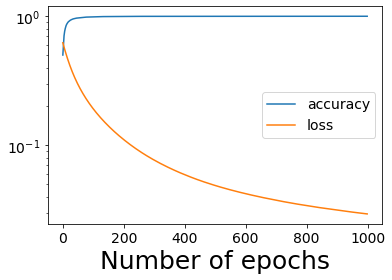

In [19]:
import time
start_time = time.time()
net_output = perceptron(train_set, train_werner_labels, test_set, test_werner_labels)
print("Time to run the script: {} seconds".format(round(time.time()-start_time,2)))

In [20]:
print("The accuracy on the training set and on the test set respectively are {} %, {} %".format(round(net_output[0],4)*100, round(net_output[1],4)*100))

The accuracy on the training set and on the test set respectively are 99.92 %, 99.92 %


Let us get the **absolute value of the perceptron weights**, in order to understand whether there are components that affect the learning process more than others. 

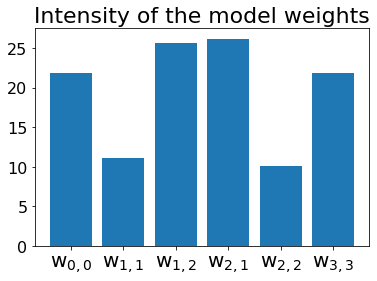

In [21]:
# Collect the absolute value of the perceptron weights into a list

n_net_weights = []

for i in range(6):
    n_net_weights.append(abs(net_output[2][0][i][0]))

plt.bar(["w$_{0,0}$", "w$_{1,1}$", "w$_{1,2}$", "w$_{2,1}$", "w$_{2,2}$", "w$_{3,3}$"], n_net_weights)
plt.title("Intensity of the model weights", fontsize = 22)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 16)
plt.show()

The perceptron weights have the same order of magnitude, i.e. there is no preferential feature in the learning process. Moreover, weights of symmetric components are equal. 

We now check how many test samples have been misclassified. 

In [22]:
# Check the model predictions

pred = net_output[3]

predlabels = []

for i in range(len(pred)):
    predlabels.append(pred[i][0])

# Convert the numpy array of the test labels into a pandas dataframe
    
test_labels = pd.DataFrame(test_werner_labels)    
    
predlabels = np.asarray(predlabels)
predlabels = pd.DataFrame(predlabels)

# Build a dataset composed of: p_sym from the test set, labels from the test set, predicted labels from the model

total = pd.concat([psym_test, test_labels, predlabels], axis = 1, ignore_index = True)
total.columns = ["psym", "actual_label", "pred_label"]

# Isolate the wrong predictions from the entire dataset

wrong = total.loc[total["actual_label"] != total["pred_label"]]

# Find the average prediction of p_sym from the model as the average of the misclassified values of p_sym

psym_av = [[np.mean(wrong["psym"].values)]]

col = ["Average psym"]

average_psym = pd.DataFrame(psym_av, columns = col)

wrong_psyms = wrong[["psym"]] # psym of the misclassified data

# Print the average of the misclassified values of p_sym and the number of misclassified data

print("The predicted boundary from the model is: {}".format(round(average_psym.values[0][0], 4)))
print("The number of misclassified targets is: {}".format(wrong["psym"].size))

The predicted boundary from the model is: 0.5003
The number of misclassified targets is: 4


In [23]:
# Dataset containing the wrong predicted labels of the test data
wrong

,psym,actual_label,pred_label
188,0.500221,0,1
1130,0.500503,0,1
3345,0.500416,0,1
3743,0.500251,0,1


From the table, we can see that the misclassified data have $p_{sym}$ close to the boundary at 0.5. Our model predicts this boundary at $p_{sym}=0.5003$, with an overestimation at the fourth decimal digit. Let us now represent $p_{sym}$ of all test data, highlighting the misclassified data with black triangles.

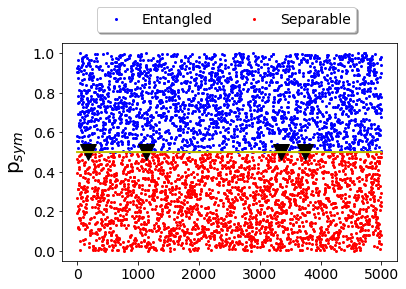

In [24]:
# Representation of the test data along with the entangled/separable boundary and the misclassified data

boundary = [0.5]*5000 # Boundary as the line p_sym = 1/2

ent_test = psym_test.loc[psym_test["p_sym"] >= 1/2]
sep_test = psym_test.loc[psym_test["p_sym"] < 1/2]

plt.plot(ent_test, "bo", marker = "o", c = "b", markersize = 2, label = "Entangled") # Entangled (1) targets
plt.plot(sep_test, "bo", marker = "o", c = "r", markersize = 2, label = "Separable") # Separable (0) targets
plt.plot(wrong_psyms, "bo", marker = "v", c = "black", markersize = 16) # Misclassified data (yellow triangles)
plt.plot(boundary, c = "y", linewidth = 2) # Boundary between entangled and separable states
plt.ylabel("p$_{sym}$", fontsize = 20) 
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.legend(loc = 1, fontsize = 14, bbox_to_anchor=(0.9, 1.2), ncol=3, fancybox = True, shadow = True)
plt.show()

### Principal component analysis
Given that all features are perfectly (anti-)correlated, we could perform a dimensionality reduction through **principal component analysis** (PCA) of the previous datasets. All of the non-zero components are linearly dependent on $p_{sym}$. As a result, a dimensionality reduction to *one single component* is supposed to enclose all of the data variance.

In [25]:
from sklearn.decomposition import PCA

# Check whether the PCA decomposition on the only one principal component yields all the data variance

pca_1 = PCA(n_components = 1)
pca_1.fit(train_set)

print("The variance enclosed by the principal component is {} %".format(round(pca_1.explained_variance_ratio_[0],3)*100))

The variance enclosed by the principal component is 100.0 %


In [26]:
# Dim. reduction on both training and test set

comp_pca_train = pca_1.fit_transform(train_set)
comp_pca_test = pca_1.fit_transform(test_set)

In [29]:
# Train and test the previous perceptron on the reduced feature space

def perceptron_pca(features_train, targets_train, features_test, targets_test): # build the model 
        
    np.random.seed(0) # Fix a random seed realization 
    model = Sequential()  
    model.add(Dense(1, activation="sigmoid")) # Output layer, made of 1 neuron and with the sigmoid activation function

    # Tune the model hyperparameters
    
    # The optimizer is the standard Adam gradient descent with the binary cross entropy loss function, compatible with
    # the sigmoid activation function on the output layer 
    
    model.compile(optimizer = "Adam", loss = "binary_crossentropy", metrics = ["binary_accuracy"])
    history = model.fit(features_train, targets_train, batch_size = 500, epochs = 1000, verbose = 0)
    loss_train, acc_train = model.evaluate(features_train, targets_train)
    loss_test, acc_test = model.evaluate(features_test, targets_test)
    
    # Show the trend loss function vs. # of epochs and accuracy vs. # of epochs
    
    plt.plot(history.history["binary_accuracy"])
    plt.plot(history.history["loss"])
    plt.xlabel("Number of epochs", fontsize = 25)
    plt.yscale("log") # logarithmic scale on both axes
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.legend(["accuracy","loss"], loc = 7, fontsize = 14)

    # The model output contains the accuracy on the training and on the test set. A comparison between them
    # could help us understand whether there has been any overfitting. 
    # Along with this, we compute the model weights and the predicted classes
    
    return acc_train, acc_test, model.get_weights(), model.predict_classes(features_test)

5000/5000 [==============================] - 0s 12us/step
Time to run the script: 34.68 seconds


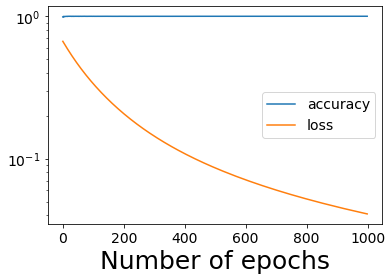

In [30]:
start_time = time.time()
pca_output = perceptron_pca(comp_pca_train, train_werner_labels, comp_pca_test, test_werner_labels)
print("Time to run the script: {} seconds".format(round(time.time()-start_time,2)))

In [31]:
print("The accuracy on the PCA-transformed training set and on the PCA-transformed test set is {} %, {} %".format(round(net_output[0],4)*100, round(net_output[1],4)*100))

The accuracy on the PCA-transformed training set and on the PCA-transformed test set is 99.92 %, 99.92 %


PCA-transformed features have identical classification accuracies (99.92 \%) as before. We can conclude that the PCA dimensionality reduction has not affected the accuracy of the model, but it has mapped a six-dimensional problem into a one-dimensional, i.e. linear, one.

### Convolutional neural networks

We now aim at checking whether a convolutional neural network can outperform the previous perceptron model. First, we reshape the input in order to build a model with a one-dimensional convolution. We convert both training and test labels into categorical variables, which requires to use two output neurons in place of one. Further, the activation function of the output layer will evaluate the probability for each point to be entangled or separable based upon majority vote.

In [32]:
# Reshape the input 

train_dtset = train_set.reshape(20000,6,1)
test_dtset = test_set.reshape(5000,6,1)

# Convert targets to categorical variables 

from keras.utils import to_categorical

tr_lab = to_categorical(train_werner_labels)
ts_lab = to_categorical(test_werner_labels)

In [33]:
from keras.layers import Dense, Conv1D, Flatten

def conv_nn(features_train, targets_train, features_test, targets_test):
    
    np.random.seed(0) # Fix a random seed realization 
    model = Sequential() 
    model.add(Conv1D(1, kernel_size = 1, activation = "relu"))
    model.add(Flatten())
    model.add(Dense(2, activation = "softmax")) # Output layer, made of 1 neuron and with the sigmoid activation function

    # Tune the model hyperparameters
    
    # The optimizer is the standard Adam gradient descent with the binary cross entropy loss function, compatible with
    # the sigmoid activation function on the output layer 
    
    model.compile(optimizer = "Adam", loss = "binary_crossentropy", metrics = ["binary_accuracy"])
    history = model.fit(features_train, targets_train, batch_size = 100, epochs = 600, verbose = 0)
    loss_train, acc_train = model.evaluate(features_train, targets_train)
    loss_test, acc_test = model.evaluate(features_test, targets_test)
    
    # Show the trend loss function vs. # of epochs and accuracy vs. # of epochs
    
    plt.plot(history.history["binary_accuracy"])
    plt.plot(history.history["loss"])
    plt.xlabel("Number of epochs", fontsize = 25)
    plt.yscale("log") # logarithmic scale on both axes
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.legend(["accuracy","loss"], loc = 7, fontsize = 14)

    # The model output contains the accuracy on the training and on the test set. A comparison between them
    # could help us understand whether there has been any overfitting. 
    # Along with this, we compute the model weights and the predicted classes
    
    return acc_train, acc_test

5000/5000 [==============================] - 0s 14us/step
Time to run the script: 108.9 seconds


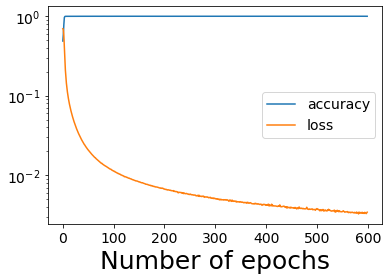

In [34]:
start_time = time.time()
acc_conv = conv_nn(train_dtset, tr_lab, test_dtset, ts_lab)
print("Time to run the script: {} seconds".format(round(time.time()-start_time,2)))

In [35]:
print("The accuracy on the training set and on the test set respectively are: {} %, {} %".format(round(acc_conv[0],3)*100, round(acc_conv[1],3)*100))

The accuracy on the training set and on the test set respectively are: 99.9 %, 100.0 %


The previous convolutional neural network outperforms indeed the single perceptron, leading to maximal accuracy on the test dataset.

## General states
Every state is a $4 \times 4$ complex matrix, so the feature space of training and test sets is made of 16 complex numbers. Each of these numbers should be split into real and imaginary part, therefore we will end up with 32 features. Unlike Werner states, all real and imaginary components of general states are non-zero. Symmetric components are complex conjugate, therefore their real part is equal and their imaginary part is opposite. As a theoretical fact, each $d \times d$ quantum state is identified by a number of independent components equal to $d^2-1$. For $4\times 4$ states, these components are $16-1=15$. As we will see, this could be checked also retaining the first 15 principal components from the PCA.

Here, the boundary between entangled and separable states is a highly non-linear function, therefore we would need a larger network than a simple perceptron. Let us show the code we used to sample uniformly general quantum states. In what follows, we are going to perform a similar analysis to the one made for Werner states.

In [ ]:
# Code to sample general states describing systems made of pairs of two-level particles 

# Import Python libraries 

import sys
import pandas as pd
import numpy as np
import qutip as qt
import random


dimspace = 2 # dimensional parameter (the single particle is a qubit, i.e. a two-level system)

nrstates_train = 20000 # training set size
nrstates_test = 5000 # test set size

# Pauli matrices 

X = qt.sigmax()
Y = qt.sigmay()
Z = qt.sigmaz()
I = qt.qeye(dimspace)



def sampling_purestates(numberOfStates, dimsingle):

    # Creating empty numpy arrays
    
    states = []
    labelsPur = []

    totalDim = dimsingle**2

    for k in range(numberOfStates): 

        prob = random.random() # parameter used to decide which sampling procedure to follow

        if prob > 0.5:

            psi = qt.rand_ket(dimsingle)
            phi = qt.rand_ket(dimsingle)
            psiPhi = qt.tensor(psi, phi)
            rho = qt.ket2dm(psiPhi)

        elif prob <= 0.5:

            nbkets = int(prob * 10 + 1)

            psi = qt.rand_ket(dimsingle)
            phi = qt.rand_ket(dimsingle)
            psiPhiEnt = qt.tensor(psi, phi)

            for k in range(nbkets):
                psi = qt.rand_ket(dimsingle)
                phi = qt.rand_ket(dimsingle)
                psiPhiEnt += qt.tensor(psi, phi)

            rho = qt.ket2dm(psiPhiEnt.unit())



        # convert rho from a quobj to an array
        
        
        rhoFull = rho.full()
        
        # appending states to the lists
        
        states.append(rhoFull)
        
        
        # PPT criterion (analytical criterion to label the states)
        
        rhoPTA = rho.ptrace(1)
        rhoPTB = rho.ptrace(0)

        rhoPTA2 = rhoPTA*rhoPTA
        rhoPTB2 = rhoPTB*rhoPTB

        trPTA2 = rhoPTA2.tr()
        trPTB2 = rhoPTB2.tr()


        if round(trPTA2,14) == 1 and round(trPTB2,14) == 1:
            labelsPur.append(0)
        else:
            labelsPur.append(1)


    # Data Frames created from the arrays
    # we use first array and then create from them data frames to have more
    # efficient code. We should remember to reshape our numpy arrays

    # To make the headers of the pandas data frames
    dmElementsList = []
    for m in range(totalDim):
        for n in range(totalDim):
            dmElementsList.append("rho(" + str(m) + "," + str(n) + ")")

    # Pandas data frames

    dfDM = pd.DataFrame(np.reshape(states, (numberOfStates, totalDim**2)), columns = dmElementsList)
    dfLabelsPUR = pd.DataFrame(np.reshape(labelsPur, (numberOfStates, 1)), columns = ["Labels"])


    return dfDM, dfLabelsPUR



pure_train, labels_train = sampling_purestates(nrstates_train, dimspace)

pure_states, labels_pure = sampling_purestates(nrstates_test, dimspace)


pure_train.to_csv("train_set.csv")
labels_train.to_csv("train_labels.csv")


pure_states.to_csv("test_set.csv")
labels_pure.to_csv("test_labels.csv") 



In [36]:
# Import the datasets

general_train = pd.read_csv("train_set.csv") # feature space of the training set
labels_general_train = pd.read_csv("train_labels.csv") # labels of the training set

general_test = pd.read_csv("test_set.csv") # features space of the test set
labels_general_test = pd.read_csv("test_labels.csv") # labels of the test set

# Drop additional columns, added while importing the datasets

labels_general_train = labels_general_train.drop(columns = ["Unnamed: 0"])
labels_general_test = labels_general_test.drop(columns = ["Unnamed: 0"])

general_train = general_train.drop(columns = ["Unnamed: 0"])
general_test = general_test.drop(columns = ["Unnamed: 0"])

In [37]:
# Show the targets of the training set
labels_general_train.head()

,Labels
0,1
1,1
2,0
3,0
4,0


In [38]:
# Show the targets of the test set
labels_general_test.head()

,Labels
0,0
1,0
2,0
3,0
4,0


In [39]:
# Check the composition of the training and of the test datasets to see whether we have balanced classes or not

train_sep = labels_general_train.loc[labels_general_train["Labels"] == 0].values
train_ent = labels_general_train.loc[labels_general_train["Labels"] == 1].values

test_sep = labels_general_test.loc[labels_general_test["Labels"] == 0].values
test_ent = labels_general_test.loc[labels_general_test["Labels"] == 1].values

train_sep_perc = train_sep.size/nrstates_train*100
train_ent_perc = train_ent.size/nrstates_train*100

test_sep_perc = test_sep.size/nrstates_test*100
test_ent_perc = test_ent.size/nrstates_test*100

print("Percentage of separable states in the training set = {} %".format(round(train_sep_perc,2)))
print("Percentage of entangled states in the training set = {} %".format(round(train_ent_perc,2)))

print("Percentage of separable states in the test set = {} %".format(round(test_sep_perc,2)))
print("Percentage of entangled states in the test set = {} %".format(round(test_ent_perc,2)))

Percentage of separable states in the training set = 49.7 %
Percentage of entangled states in the training set = 50.3 %
Percentage of separable states in the test set = 49.72 %
Percentage of entangled states in the test set = 50.28 %


In [40]:
# Check the feature space of the training set 
general_train.head()

,"rho(0,0)","rho(0,1)","rho(0,2)","rho(0,3)","rho(1,0)","rho(1,1)","rho(1,2)","rho(1,3)","rho(2,0)","rho(2,1)","rho(2,2)","rho(2,3)","rho(3,0)","rho(3,1)","rho(3,2)","rho(3,3)"
0,(0.05347348350690947+0j),(0.02037055098459143-0.02039645187856153j),(0.19103952630683146-0.006027367805933173j),(0.056842648516309234-0.10009784716636119j),(0.02037055098459143+0.02039645187856153j),(0.01553993759435819+0j),(0.07507491685285261+0.07057231836297355j),(0.05983445967501923-0.01645039552965817j),(0.19103952630683146+0.006027367805933173j),(0.07507491685285261-0.07057231836297355j),(0.683187766689748+0j),(0.21435893897868227-0.35120273686485104j),(0.056842648516309234+0.10009784716636119j),(0.05983445967501923+0.01645039552965817j),(0.21435893897868227+0.35120273686485104j),(0.24779881220898425+0j)
1,(0.060807688150406054+0j),(0.08797496720788356+0.026243395929988707j),(-0.10443585786683318-0.16160933286883744j),(0.09744316696468948-0.04649953612932324j),(0.08797496720788356-0.026243395929988707j),(0.13860600429865302+0j),(-0.22084245081648285-0.1887396896910304j),(0.1209099359765602-0.1093288526451068j),(-0.10443585786683318+0.16160933286883744j),(-0.22084245081648285+0.1887396896910304j),(0.6088773641108217+0j),(-0.04377409836835404+0.33883781440436656j),(0.09744316696468948+0.04649953612932324j),(0.1209099359765602+0.1093288526451068j),(-0.04377409836835404-0.33883781440436656j),(0.19170894344011902+0j)
2,(0.005376008547605305+0j),(-0.0020197609023759598+0.005152857965634789j),(-0.05076655557538025-0.0019368388157479655j),(0.020929386258034588-0.0479316386289916j),(-0.0020197609023759598-0.005152857965634789j),(0.005697792152956478+0j),(0.017216499557241225+0.04938697534566942j),(-0.05380521244127814-0.002052769244726386j),(-0.05076655557538025+0.0019368388157479655j),(0.017216499557241225-0.04938697534566942j),(0.48009494157817895+0j),(-0.18037117758304366+0.46016687326028305j),(0.020929386258034588+0.0479316386289916j),(-0.05380521244127814+0.002052769244726386j),(-0.18037117758304366-0.46016687326028305j),(0.5088312577212593+0j)
3,(0.2937530508943436+0j),(-0.04424486747467146-0.2302469575787628j),(-0.20345100776821812-0.22750324435921357j),(-0.1476759708355046+0.1937335672886878j),(-0.04424486747467146+0.2302469575787628j),(0.18713429394100073+0j),(0.20896325175999012-0.1252008261574193j),(-0.1296077115603624-0.14493009986732416j),(-0.20345100776821812+0.22750324435921357j),(0.20896325175999012+0.1252008261574193j),(0.31710322147215947+0j),(-0.047761852913907034-0.24854908488644128j),(-0.1476759708355046-0.1937335672886878j),(-0.1296077115603624+0.14493009986732416j),(-0.047761852913907034+0.24854908488644128j),(0.20200943369249608+0j)
4,(0.05764777899367143+0j),(0.07088497983829455-0.019271735537371402j),(-0.05877411809792195-0.12326412137399771j),(-0.11347732452049927-0.13192000855384903j),(0.07088497983829455+0.019271735537371402j),(0.09360430274148447+0j),(-0.031062577939302546-0.17121655319782336j),(-0.09543317088426953-0.20014738357086428j),(-0.05877411809792195+0.12326412137399771j),(-0.031062577939302546+0.17121655319782336j),(0.3234893156653848+0j),(0.39776959354083385-0.10814294409075056j),(-0.11347732452049927+0.13192000855384903j),(-0.09543317088426953+0.20014738357086428j),(0.39776959354083385+0.10814294409075056j),(0.5252586025994592+0j)


In [41]:
# Check the feature space of the test set
general_test.head()

,"rho(0,0)","rho(0,1)","rho(0,2)","rho(0,3)","rho(1,0)","rho(1,1)","rho(1,2)","rho(1,3)","rho(2,0)","rho(2,1)","rho(2,2)","rho(2,3)","rho(3,0)","rho(3,1)","rho(3,2)","rho(3,3)"
0,(0.0654804787485705+0j),(-0.031046696237585783+0.02308405226435933j),(-0.008521628963953311+0.2101823779446633j),(-0.07005588015388181-0.10265933144341187j),(-0.031046696237585783-0.02308405226435933j),(0.022858275394714824+0j),(0.07813671373816733-0.09665101470105235j),(-0.0029747757712274767+0.07337158753256721j),(-0.008521628963953311-0.2101823779446633j),(0.07813671373816733+0.09665101470105235j),(0.6757624715692624+0j),(-0.32040376894814776+0.23822880513588227j),(-0.07005588015388181+0.10265933144341187j),(-0.0029747757712274767-0.07337158753256721j),(-0.32040376894814776-0.23822880513588227j),(0.2358987742874522+0j)
1,(0.2865752420148217+0j),(-0.350980923162389-0.06688504631230408j),(-0.16138575568448219-0.06336537635385366j),(0.18286689741560033+0.11527280514554011j),(-0.350980923162389+0.06688504631230408j),(0.4454719010148098+0j),(0.21244514082718488+0.03993975357268653j),(-0.25086891273657064-0.09849941838803412j),(-0.16138575568448219+0.06336537635385366j),(0.21244514082718488-0.03993975357268653j),(0.10489577831975504+0j),(-0.12847033418400036-0.024482083454086825j),(0.18286689741560033-0.11527280514554011j),(-0.25086891273657064+0.09849941838803412j),(-0.12847033418400036+0.024482083454086825j),(0.16305707865061336+0j)
2,(0.4322363703387836+0j),(-0.15785350189592515+0.36267566718833144j),(-0.1804703880245037+0.1258757448708042j),(-0.039710186817943166-0.1973969600227384j),(-0.15785350189592515-0.36267566718833144j),(0.361957897038333+0j),(0.1715264091124981+0.10545686198776472j),(-0.15112722253299019+0.10540926915950893j),(-0.1804703880245037-0.1258757448708042j),(0.1715264091124981-0.10545686198776472j),(0.11200876979081602+0j),(-0.040905804712075944+0.09398296418922022j),(-0.039710186817943166+0.1973969600227384j),(-0.15112722253299019-0.10540926915950893j),(-0.040905804712075944-0.09398296418922022j),(0.09379696283206723+0j)
3,(0.2890269646048582+0j),(-0.09246102469810215-0.30051235996820597j),(-0.2122835373421186+0.061434353979974876j),(0.13178609870850183+0.20106616539350947j),(-0.09246102469810215+0.30051235996820597j),(0.34203286090290963+0j),(0.0040348162433219426-0.24037241717122976j),(-0.25121512693108083+0.0727010639931817j),(-0.2122835373421186-0.061434353979974876j),(0.0040348162433219426+0.24037241717122976j),(0.16897551459321036+0j),(-0.05405602639718109-0.1756902880555461j),(0.13178609870850183-0.20106616539350947j),(-0.25121512693108083-0.0727010639931817j),(-0.05405602639718109+0.1756902880555461j),(0.19996465989902182+0j)
4,(0.35438359303486977+0j),(-0.26311323157290606-0.0928995223159682j),(0.11303635494878088+0.28354235830007124j),(-0.009595283360201948-0.24014872932009743j),(-0.26311323157290606+0.0928995223159682j),(0.21970230960328846+0j),(-0.15825312283206422-0.1808851314252213j),(0.07007759032721551+0.17578384612957876j),(0.11303635494878088-0.28354235830007124j),(-0.15825312283206422+0.1808851314252213j),(0.2629170433443427+0j),(-0.1952035993469853-0.06892211777144222j),(-0.009595283360201948+0.24014872932009743j),(0.07007759032721551-0.17578384612957876j),(-0.1952035993469853+0.06892211777144222j),(0.16299705401749887+0j)


In [42]:
# Split data into real and imaginary part

for col in general_train.columns:
    general_train[col] = general_train[col].apply(lambda x: np.complex(x)) # read features as complex numbers
    general_test[col] = general_test[col].apply(lambda x: np.complex(x))

for col in general_train.columns:
    general_train["Re-" + col] = general_train[col].apply(lambda x: np.real(x)) # real parts of features
    general_train["Im-" + col] = general_train[col].apply(lambda x: np.imag(x)) # imaginary parts of features
    general_test["Re-" + col] = general_test[col].apply(lambda x: np.real(x))
    general_test["Im-" + col] = general_test[col].apply(lambda x: np.imag(x))
    
general_train = general_train.drop(columns = general_train.columns[:16])
general_test = general_test.drop(columns = general_test.columns[:16])

In [43]:
# Show the feature space of the training set
general_train.head()

,"Re-rho(0,0)","Im-rho(0,0)","Re-rho(0,1)","Im-rho(0,1)","Re-rho(0,2)","Im-rho(0,2)","Re-rho(0,3)","Im-rho(0,3)","Re-rho(1,0)","Im-rho(1,0)",...,"Re-rho(2,3)","Im-rho(2,3)","Re-rho(3,0)","Im-rho(3,0)","Re-rho(3,1)","Im-rho(3,1)","Re-rho(3,2)","Im-rho(3,2)","Re-rho(3,3)","Im-rho(3,3)"
0,0.053473,0.0,0.020371,-0.020396,0.191040,-0.006027,0.056843,-0.100098,0.020371,0.020396,...,0.214359,-0.351203,0.056843,0.100098,0.059834,0.016450,0.214359,0.351203,0.247799,0.0
1,0.060808,0.0,0.087975,0.026243,-0.104436,-0.161609,0.097443,-0.046500,0.087975,-0.026243,...,-0.043774,0.338838,0.097443,0.046500,0.120910,0.109329,-0.043774,-0.338838,0.191709,0.0
2,0.005376,0.0,-0.002020,0.005153,-0.050767,-0.001937,0.020929,-0.047932,-0.002020,-0.005153,...,-0.180371,0.460167,0.020929,0.047932,-0.053805,0.002053,-0.180371,-0.460167,0.508831,0.0
3,0.293753,0.0,-0.044245,-0.230247,-0.203451,-0.227503,-0.147676,0.193734,-0.044245,0.230247,...,-0.047762,-0.248549,-0.147676,-0.193734,-0.129608,0.144930,-0.047762,0.248549,0.202009,0.0
4,0.057648,0.0,0.070885,-0.019272,-0.058774,-0.123264,-0.113477,-0.131920,0.070885,0.019272,...,0.397770,-0.108143,-0.113477,0.131920,-0.095433,0.200147,0.397770,0.108143,0.525259,0.0


In [44]:
# Show the feature space of the test set
general_test.head()

,"Re-rho(0,0)","Im-rho(0,0)","Re-rho(0,1)","Im-rho(0,1)","Re-rho(0,2)","Im-rho(0,2)","Re-rho(0,3)","Im-rho(0,3)","Re-rho(1,0)","Im-rho(1,0)",...,"Re-rho(2,3)","Im-rho(2,3)","Re-rho(3,0)","Im-rho(3,0)","Re-rho(3,1)","Im-rho(3,1)","Re-rho(3,2)","Im-rho(3,2)","Re-rho(3,3)","Im-rho(3,3)"
0,0.065480,0.0,-0.031047,0.023084,-0.008522,0.210182,-0.070056,-0.102659,-0.031047,-0.023084,...,-0.320404,0.238229,-0.070056,0.102659,-0.002975,-0.073372,-0.320404,-0.238229,0.235899,0.0
1,0.286575,0.0,-0.350981,-0.066885,-0.161386,-0.063365,0.182867,0.115273,-0.350981,0.066885,...,-0.128470,-0.024482,0.182867,-0.115273,-0.250869,0.098499,-0.128470,0.024482,0.163057,0.0
2,0.432236,0.0,-0.157854,0.362676,-0.180470,0.125876,-0.039710,-0.197397,-0.157854,-0.362676,...,-0.040906,0.093983,-0.039710,0.197397,-0.151127,-0.105409,-0.040906,-0.093983,0.093797,0.0
3,0.289027,0.0,-0.092461,-0.300512,-0.212284,0.061434,0.131786,0.201066,-0.092461,0.300512,...,-0.054056,-0.175690,0.131786,-0.201066,-0.251215,-0.072701,-0.054056,0.175690,0.199965,0.0
4,0.354384,0.0,-0.263113,-0.092900,0.113036,0.283542,-0.009595,-0.240149,-0.263113,0.092900,...,-0.195204,-0.068922,-0.009595,0.240149,0.070078,-0.175784,-0.195204,0.068922,0.162997,0.0


In [45]:
# Columns with zero variance

zero_var_cols = [] # empty array 

for item in general_train.columns:
    if general_train[item].var() == 0:
        zero_var_cols.append(item) # append zero-variance columns to the empty array 
    
general_train = general_train.drop(columns = zero_var_cols)    
general_test = general_test.drop(columns = zero_var_cols)

In [46]:
# Display training dataset without zero-variance columns
general_train.head()

,"Re-rho(0,0)","Re-rho(0,1)","Im-rho(0,1)","Re-rho(0,2)","Im-rho(0,2)","Re-rho(0,3)","Im-rho(0,3)","Re-rho(1,0)","Im-rho(1,0)","Re-rho(1,1)",...,"Re-rho(2,2)","Re-rho(2,3)","Im-rho(2,3)","Re-rho(3,0)","Im-rho(3,0)","Re-rho(3,1)","Im-rho(3,1)","Re-rho(3,2)","Im-rho(3,2)","Re-rho(3,3)"
0,0.053473,0.020371,-0.020396,0.191040,-0.006027,0.056843,-0.100098,0.020371,0.020396,0.015540,...,0.683188,0.214359,-0.351203,0.056843,0.100098,0.059834,0.016450,0.214359,0.351203,0.247799
1,0.060808,0.087975,0.026243,-0.104436,-0.161609,0.097443,-0.046500,0.087975,-0.026243,0.138606,...,0.608877,-0.043774,0.338838,0.097443,0.046500,0.120910,0.109329,-0.043774,-0.338838,0.191709
2,0.005376,-0.002020,0.005153,-0.050767,-0.001937,0.020929,-0.047932,-0.002020,-0.005153,0.005698,...,0.480095,-0.180371,0.460167,0.020929,0.047932,-0.053805,0.002053,-0.180371,-0.460167,0.508831
3,0.293753,-0.044245,-0.230247,-0.203451,-0.227503,-0.147676,0.193734,-0.044245,0.230247,0.187134,...,0.317103,-0.047762,-0.248549,-0.147676,-0.193734,-0.129608,0.144930,-0.047762,0.248549,0.202009
4,0.057648,0.070885,-0.019272,-0.058774,-0.123264,-0.113477,-0.131920,0.070885,0.019272,0.093604,...,0.323489,0.397770,-0.108143,-0.113477,0.131920,-0.095433,0.200147,0.397770,0.108143,0.525259


In [47]:
# Display test dataset without zero-variance columns
general_test.head()

,"Re-rho(0,0)","Re-rho(0,1)","Im-rho(0,1)","Re-rho(0,2)","Im-rho(0,2)","Re-rho(0,3)","Im-rho(0,3)","Re-rho(1,0)","Im-rho(1,0)","Re-rho(1,1)",...,"Re-rho(2,2)","Re-rho(2,3)","Im-rho(2,3)","Re-rho(3,0)","Im-rho(3,0)","Re-rho(3,1)","Im-rho(3,1)","Re-rho(3,2)","Im-rho(3,2)","Re-rho(3,3)"
0,0.065480,-0.031047,0.023084,-0.008522,0.210182,-0.070056,-0.102659,-0.031047,-0.023084,0.022858,...,0.675762,-0.320404,0.238229,-0.070056,0.102659,-0.002975,-0.073372,-0.320404,-0.238229,0.235899
1,0.286575,-0.350981,-0.066885,-0.161386,-0.063365,0.182867,0.115273,-0.350981,0.066885,0.445472,...,0.104896,-0.128470,-0.024482,0.182867,-0.115273,-0.250869,0.098499,-0.128470,0.024482,0.163057
2,0.432236,-0.157854,0.362676,-0.180470,0.125876,-0.039710,-0.197397,-0.157854,-0.362676,0.361958,...,0.112009,-0.040906,0.093983,-0.039710,0.197397,-0.151127,-0.105409,-0.040906,-0.093983,0.093797
3,0.289027,-0.092461,-0.300512,-0.212284,0.061434,0.131786,0.201066,-0.092461,0.300512,0.342033,...,0.168976,-0.054056,-0.175690,0.131786,-0.201066,-0.251215,-0.072701,-0.054056,0.175690,0.199965
4,0.354384,-0.263113,-0.092900,0.113036,0.283542,-0.009595,-0.240149,-0.263113,0.092900,0.219702,...,0.262917,-0.195204,-0.068922,-0.009595,0.240149,0.070078,-0.175784,-0.195204,0.068922,0.162997


In [48]:
# Let us check if we have equal real parts and opposite imaginary parts in the feature space

# Training set 

for i in range(4):
    for j in range(i+1,4):
        if all(general_train[["Re-rho(" + str(i) + "," + str(j) +")"]].values == general_train[["Re-rho(" + str(j) + "," + str(i) +")"]].values):
            print("Training dataset, equal real parts for the symmetric components rho("+str(i)+","+str(j)+")")
        if all(general_train[["Im-rho(" + str(i) + "," + str(j) +")"]].values == - general_train[["Im-rho(" + str(j) + "," + str(i) +")"]].values):
            print("Training dataset, opposite imaginary parts for the symmetric components rho("+str(i)+","+str(j)+")")

            
# Test set

for i in range(4):
    for j in range(i+1,4):
        if all(general_test[["Re-rho(" + str(i) + "," + str(j) +")"]].values == general_test[["Re-rho(" + str(j) + "," + str(i) +")"]].values):
            print("Test dataset, equal real parts for the symmetric components rho("+str(i)+","+str(j)+")")
        if all(general_test[["Im-rho(" + str(i) + "," + str(j) +")"]].values == - general_test[["Im-rho(" + str(j) + "," + str(i) +")"]].values):
            print("Test dataset, opposite imaginary parts for the symmetric components rho("+str(i)+","+str(j)+")")

Training dataset, equal real parts for the symmetric components rho(0,1)
Training dataset, opposite imaginary parts for the symmetric components rho(0,1)
Training dataset, equal real parts for the symmetric components rho(0,2)
Training dataset, opposite imaginary parts for the symmetric components rho(0,2)
Training dataset, equal real parts for the symmetric components rho(0,3)
Training dataset, opposite imaginary parts for the symmetric components rho(0,3)
Training dataset, equal real parts for the symmetric components rho(1,2)
Training dataset, opposite imaginary parts for the symmetric components rho(1,2)
Training dataset, equal real parts for the symmetric components rho(1,3)
Training dataset, opposite imaginary parts for the symmetric components rho(1,3)
Training dataset, equal real parts for the symmetric components rho(2,3)
Training dataset, opposite imaginary parts for the symmetric components rho(2,3)
Test dataset, equal real parts for the symmetric components rho(0,1)
Test da

In [49]:
# Compute the correlation matrix of the training set and of the test set

general_train.corr()

,"Re-rho(0,0)","Re-rho(0,1)","Im-rho(0,1)","Re-rho(0,2)","Im-rho(0,2)","Re-rho(0,3)","Im-rho(0,3)","Re-rho(1,0)","Im-rho(1,0)","Re-rho(1,1)",...,"Re-rho(2,2)","Re-rho(2,3)","Im-rho(2,3)","Re-rho(3,0)","Im-rho(3,0)","Re-rho(3,1)","Im-rho(3,1)","Re-rho(3,2)","Im-rho(3,2)","Re-rho(3,3)"
"Re-rho(0,0)",1.000000,0.000250,0.000680,0.006801,0.005300,-0.006788,0.004553,0.000250,-0.000680,-0.222339,...,-0.213425,0.006366,0.002479,-0.006788,-0.004553,0.002957,-0.002173,0.006366,-0.002479,-0.572114
"Re-rho(0,1)",0.000250,1.000000,-0.000686,-0.001112,-0.002623,-0.009462,-0.003157,1.000000,0.000686,-0.003851,...,-0.000350,0.373721,-0.003240,-0.009462,0.003157,0.001712,-0.002979,0.373721,0.003240,0.003952
"Im-rho(0,1)",0.000680,-0.000686,1.000000,0.001095,-0.002050,-0.002962,0.009132,-0.000686,-1.000000,-0.003684,...,0.002978,-0.002188,0.377292,-0.002962,-0.009132,0.004606,0.007331,-0.002188,-0.377292,-0.000002
"Re-rho(0,2)",0.006801,-0.001112,0.001095,1.000000,-0.002719,0.007383,-0.017383,-0.001112,-0.001095,-0.003922,...,0.009949,-0.005747,0.004205,0.007383,0.017383,0.369995,0.003883,-0.005747,-0.004205,-0.012966
"Im-rho(0,2)",0.005300,-0.002623,-0.002050,-0.002719,1.000000,-0.004621,0.006659,-0.002623,0.002050,0.003515,...,-0.005926,-0.000031,-0.007008,-0.004621,-0.006659,-0.002975,-0.374140,-0.000031,0.007008,-0.002897
"Re-rho(0,3)",-0.006788,-0.009462,-0.002962,0.007383,-0.004621,1.000000,-0.009532,-0.009462,0.002962,0.007742,...,-0.000203,-0.003186,0.003504,1.000000,0.009532,-0.008988,-0.008802,-0.003186,-0.003504,-0.000687
"Im-rho(0,3)",0.004553,-0.003157,0.009132,-0.017383,0.006659,-0.009532,1.000000,-0.003157,-0.009132,-0.000082,...,-0.003656,-0.007614,0.001259,-0.009532,-1.000000,-0.005135,-0.005794,-0.007614,-0.001259,-0.000831
"Re-rho(1,0)",0.000250,1.000000,-0.000686,-0.001112,-0.002623,-0.009462,-0.003157,1.000000,0.000686,-0.003851,...,-0.000350,0.373721,-0.003240,-0.009462,0.003157,0.001712,-0.002979,0.373721,0.003240,0.003952
"Im-rho(1,0)",-0.000680,0.000686,-1.000000,-0.001095,0.002050,0.002962,-0.009132,0.000686,1.000000,0.003684,...,-0.002978,0.002188,-0.377292,0.002962,0.009132,-0.004606,-0.007331,0.002188,0.377292,0.000002
"Re-rho(1,1)",-0.222339,-0.003851,-0.003684,-0.003922,0.003515,0.007742,-0.000082,-0.003851,0.003684,1.000000,...,-0.571320,-0.003957,0.003588,0.007742,0.000082,-0.013122,0.000381,-0.003957,-0.003588,-0.200227


The correlation is equal to $\pm 1$ or is of the order $O(1)$ among diagonal components or among symmetric components. 

In [50]:
# Converting features and labels from both training and the test set into numpy arrays

training_dt = general_train.values
training_targets = labels_general_train.values

test_dt = general_test.values
test_targets = labels_general_test.values

In [51]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam 
    
def ff_net(features_train, targets_train, features_test, targets_test): # build the model 
        
    np.random.seed(0) # Fix a random seed realization 
    model = Sequential()  
    model.add(Dense(15, activation = "tanh")) # 1st hidden layer, made of 15 neurons with the tanh activation function
    model.add(Dense(15, activation = "tanh")) # 2nd hidden layer, made of 15 neurons with the tanh activation function
    model.add(Dense(1, activation = "sigmoid")) # Output layer, made of 1 neuron and with the sigmoid activation function

    # Tune the model hyperparameters
    
    # The optimizer is the standard Adam gradient descent with the binary cross entropy loss function, compatible with
    # the sigmoid activation function on the output layer 
    
    opt = Adam(lr = 0.00001, beta_1 = 0.99, beta_2 = 0.999)
    model.compile(optimizer = "Adam", loss = "binary_crossentropy", metrics = ["binary_accuracy"])
    history = model.fit(features_train, targets_train, batch_size = 50, epochs = 1000, verbose = 0)
    loss_train, acc_train = model.evaluate(features_train, targets_train)
    loss_test, acc_test = model.evaluate(features_test, targets_test)
    
    # Show the trend loss function vs. # of epochs and accuracy vs. # of epochs
    
    plt.plot(history.history["binary_accuracy"])
    plt.plot(history.history["loss"])
    plt.xlabel("Number of epochs", fontsize = 25)
    plt.yscale("log") # logarithmic scale on both axes
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.legend(["accuracy","loss"], loc = 7, fontsize = 14)

    # The model output contains the accuracy on the training and on the test set. A comparison between them
    # could help us understand whether there has been any overfitting. 
    # Along with this, we compute the model weights and the predicted classes
    
    return acc_train, acc_test, model.predict_classes(features_test)

5000/5000 [==============================] - 0s 18us/step
Time to run the script: 338.65 seconds


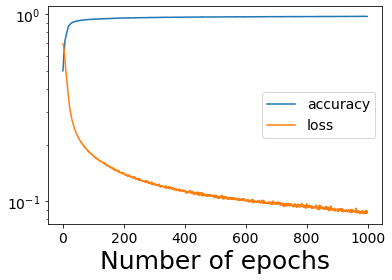

In [52]:
start_time = time.time()
net_output = ff_net(training_dt, training_targets, test_dt, test_targets)
print("Time to run the script: {} seconds".format(round(time.time()-start_time,2)))

In [53]:
print("The accuracies on the training set and on the test set respectively are {} %, {} %".format(round(net_output[0],2)*100, round(net_output[1],2)*100))

The accuracies on the training set and on the test set respectively are 97.0 %, 97.0 %


In [54]:
# Retrieve the model predictions

pr = net_output[2]

predlabels = []

for i in range(len(pr)):
    predlabels.append(pr[i][0])

# Convert the numpy array of the test labels into a pandas dataframe
    
test_labels = pd.DataFrame(test_targets)    

predlabels = pd.DataFrame(predlabels)

# Build a dataset composed of: p_sym from the test set, labels from the test set, predicted labels from the model

total = pd.concat([test_labels, predlabels], axis=1, ignore_index=True)
total.columns = ["actual_label", "pred_label"]
total
# Isolate the wrong predictions from the entire dataset

wrong = total.loc[total['actual_label'] != total['pred_label']]
wrong
# Print the number of misclassified data

print("The number of misclassified targets is {} out of 5000".format(wrong["actual_label"].size))

The number of misclassified targets is 167 out of 5000


Unlike the case of Werner states, quantum entanglement of general states does not depend on one parameter but it is a high-dimensional problem. Therefore, it is not possible to give a 2D or 3D representation of such parameters. 

In [55]:
pca_20 = PCA(n_components = 20)
pca_20.fit(training_dt)

# How many components should I retain? 

count = 0

for item in pca_20.explained_variance_ratio_:
    if item >= 10**(-20):
        count += 1
        
print("The number of principal components that enclose most variance is {}".format(count))

The number of principal components that enclose most variance is 15


The PCA reduction we have just performed confirms the initial statement, i.e. a $4 \times 4$ general state is identified by a number of independent components given by $4^2-1=15$. 

In [56]:
# PCA reduction to 15 components

pca_15 = PCA(n_components = 15)
train_transf = pca_15.fit_transform(training_dt)
test_transf = pca_15.fit_transform(test_dt)

5000/5000 [==============================] - 0s 15us/step
Time to run the script: 350.84 seconds


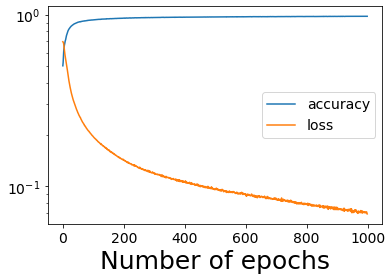

In [57]:
# Train and test the previous perceptron on the reduced feature space

start_time = time.time()
pca_output = ff_net(train_transf, training_targets, test_transf, test_targets)
print("Time to run the script: {} seconds".format(round(time.time()-start_time,2)))

In [58]:
print("The accuracy on the PCA-transformed training set and on the PCA-transformed test set is {} %, {} %".format(round(net_output[0],2)*100, round(net_output[1],2)*100))

The accuracy on the PCA-transformed training set and on the PCA-transformed test set is 97.0 %, 97.0 %


The PCA-transformed components are associated with the same classification accuracy as the non-transformed components. This result has been obtained both for Werner states and for general states and is due to the fact that the dimensional reduction is carried out with no overall variance loss. 

## Conclusions
Werner states can be learned with a perceptron at highest accuracy. This classification problem is linear, therefore it can be solved with a perceptron. 

When it comes to general quantum states, while our model may be still improved, on the other hand this might come with a higher computational cost due to a much larger network architecture, for example. Another difficulty of general quantum states is due to high dimensionality of the problem. Indeed, their entangled/separable boundary is 15-dimensional and highly non-linear. In spite of this, a structurally simple network as ours, composed of 2 hidden layers and 15 neurons/layer, has given a classification accuracy equal to 97\% on the test data, within an execution time of about 5-6 minutes. Therefore, we should expect that an improvement of such model may be possible, increasing the number of neurons or choosing a deeper neural network. This solution should be applied taking into account some possible issues like overfitting, which may be prevented adding dropout layers for instance. 